# Notebook for plotting and saving number of tornadoes by county in the US for a given year. 

### First we will import all the data files from the NOAA website and save them in a seperate csv file. We are interested in the following parameters: state, county, tornado scale

In [1]:
import pandas as pd
import requests
from io import BytesIO

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
year = 2003
creation = "20250520"

details_file = f"StormEvents_details-ftp_v1.0_d{year}_c{creation}.csv.gz"
locations_file = f"StormEvents_locations-ftp_v1.0_d{year}_c{creation}.csv.gz"

#function for downloading files
def download_csv_gz(file_name):
    url = base_url + file_name
    print(f"Downloading {url}")
    r = requests.get(url)
    r.raise_for_status()
    return pd.read_csv(BytesIO(r.content), compression='gzip', low_memory=False)


df_details = download_csv_gz(details_file)
df_locations = download_csv_gz(locations_file)

df_details.columns = df_details.columns.str.lower()
df_locations.columns = df_locations.columns.str.lower()

assert 'event_id' in df_details.columns, "event_id missing from details"
assert 'event_id' in df_locations.columns, "event_id missing from locations"

# Merge the two datasets on 'event_id'
df_merged = pd.merge(df_details, df_locations, on='event_id', suffixes=('_details', '_loc'), how='inner')

# Filter for tornadoes with valid EF scale
df_tornadoes = df_merged[
    (df_merged['event_type'] == 'Tornado') &
    (df_merged['tor_f_scale'].isin(['F0', 'F1', 'F2', 'F3', 'F4', 'F5']))
]

# Group by county (cz_name) and tornado scale (tor_f_scale)
tornado_summary = df_tornadoes.groupby(['state','cz_name', 'tor_f_scale']).size().reset_index(name='count')


#print(tornado_summary.head())


tornado_summary.to_csv("tornado_2003_summary.csv", index=False)


     state   cz_name tor_f_scale  count
0  ALABAMA   CALHOUN          F1      2
1  ALABAMA      CLAY          F0      6
2  ALABAMA  CLEBURNE          F1      2
3  ALABAMA   COLBERT          F0      1
4  ALABAMA   CONECUH          F0      1


In [5]:
pip install geopandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 13.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


## Get the counties data from censes.gov https://www2.census.gov/geo/tiger/GENZ2022/shp/

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load US counties shapefile
counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_5m.zip")


counties['STATE_NAME'] = counties['STATE_NAME'].str.upper()
counties['NAME'] = counties['NAME'].str.upper()


In [3]:
tornado_summary.columns = tornado_summary.columns.str.lower()


tornado_summary = tornado_summary.rename(columns={
    'cz_name': 'NAME',
    'state': 'STATE_NAME'
})

# Merge with counties shapefile
merged = counties.merge(tornado_summary, how='left', on=['STATE_NAME', 'NAME'])

# Fill NaNs (counties without tornadoes)
merged['count'] = merged['count'].fillna(0)


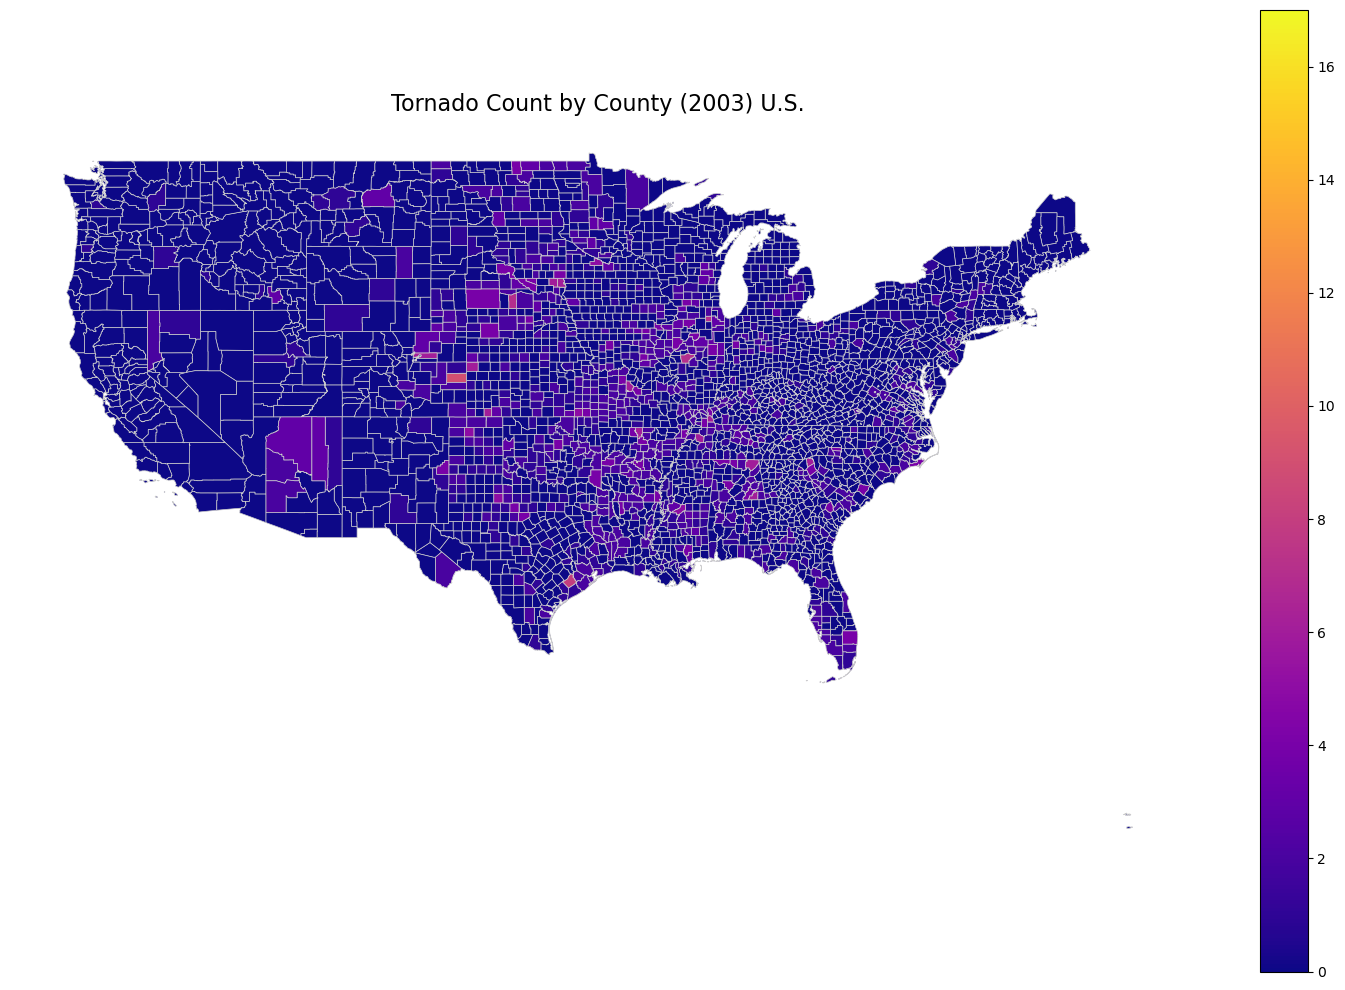

In [6]:
# Exclude Alaska, Hawaii, Puerto Rico, etc.
contiguous_states = [
    'ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
    'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS'
]


contiguous_counties = merged[~merged['STATE_NAME'].isin(contiguous_states)]




fig, ax = plt.subplots(1, 1, figsize=(15, 10))
contiguous_counties.plot(column='count', cmap='plasma', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)
ax.set_title("Tornado Count by County (2003) U.S.", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [7]:
merged

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,tor_f_scale,count
0,13,233,00343585,0500000US13233,13233,POLK,Polk County,GA,GEORGIA,06,803775591,4664760,"POLYGON ((-85.42188 34.08082, -85.28332 34.079...",NaN,0.0
1,21,023,00516858,0500000US21023,21023,BRACKEN,Bracken County,KY,KENTUCKY,06,524900457,16279752,"POLYGON ((-84.23042 38.8274, -84.23018 38.8265...",NaN,0.0
2,28,153,00695797,0500000US28153,28153,WAYNE,Wayne County,MS,MISSISSIPPI,06,2099745602,7255476,"POLYGON ((-88.94296 31.56566, -88.94272 31.607...",F0,1.0
3,42,001,01213656,0500000US42001,42001,ADAMS,Adams County,PA,PENNSYLVANIA,06,1343400757,7771555,"POLYGON ((-77.47108 39.94408, -77.42136 39.981...",NaN,0.0
4,04,007,00040471,0500000US04007,04007,GILA,Gila County,AZ,ARIZONA,06,12322070148,96465330,"POLYGON ((-111.72051 34.16039, -111.69497 34.1...",NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3455,27,041,00659466,0500000US27041,27041,DOUGLAS,Douglas County,MN,MINNESOTA,06,1649506061,215746732,"POLYGON ((-95.76975 46.10745, -95.4853 46.1081...",NaN,0.0
3456,47,023,01639732,0500000US47023,47023,CHESTER,Chester County,TN,TENNESSEE,06,740053474,575590,"POLYGON ((-88.84161 35.42783, -88.8158 35.4274...",NaN,0.0
3457,22,113,00559538,0500000US22113,22113,VERMILION,Vermilion Parish,LA,LOUISIANA,15,3035611921,932167176,"POLYGON ((-92.72387 30.04865, -92.69763 30.054...",F1,1.0
3458,35,043,00929113,0500000US35043,35043,SANDOVAL,Sandoval County,NM,NEW MEXICO,06,9609358329,10852149,"MULTIPOLYGON (((-106.27698 35.85555, -106.2483...",NaN,0.0


In [12]:
tornado_summary.keys()

Index(['STATE_NAME', 'NAME', 'tor_f_scale', 'count'], dtype='object')

In [13]:
tornado_summary['tor_f_scale']

0       F1
1       F0
2       F1
3       F0
4       F0
        ..
1071    F0
1072    F0
1073    F0
1074    F0
1075    F0
Name: tor_f_scale, Length: 1076, dtype: object

In [23]:
tornado_summary['severity'] = tornado_summary['tor_f_scale'].map({
    'F0': 'Low',
    'F1': 'Low',
    'F2': 'Low',
    'F3': 'High',
    'F4': 'High',
    'F5': 'High',
})
tornado_severity_summary = (
    tornado_summary
    .groupby(['STATE_NAME', 'NAME', 'severity'])['count']
    .sum()
    .reset_index()
)


tornado_severity_summary = tornado_severity_summary.pivot_table(
    index=['STATE_NAME', 'NAME'],
    columns='severity',
    values='count',
    fill_value=0
).reset_index()


In [24]:
tornado_severity_summary

severity,STATE_NAME,NAME,High,Low
0,ALABAMA,CALHOUN,0,2
1,ALABAMA,CLAY,0,6
2,ALABAMA,CLEBURNE,0,2
3,ALABAMA,COLBERT,0,1
4,ALABAMA,CONECUH,0,1
...,...,...,...,...
846,WISCONSIN,WINNEBAGO,0,3
847,WISCONSIN,WOOD,0,2
848,WYOMING,CAMPBELL,0,2
849,WYOMING,NATRONA,0,1


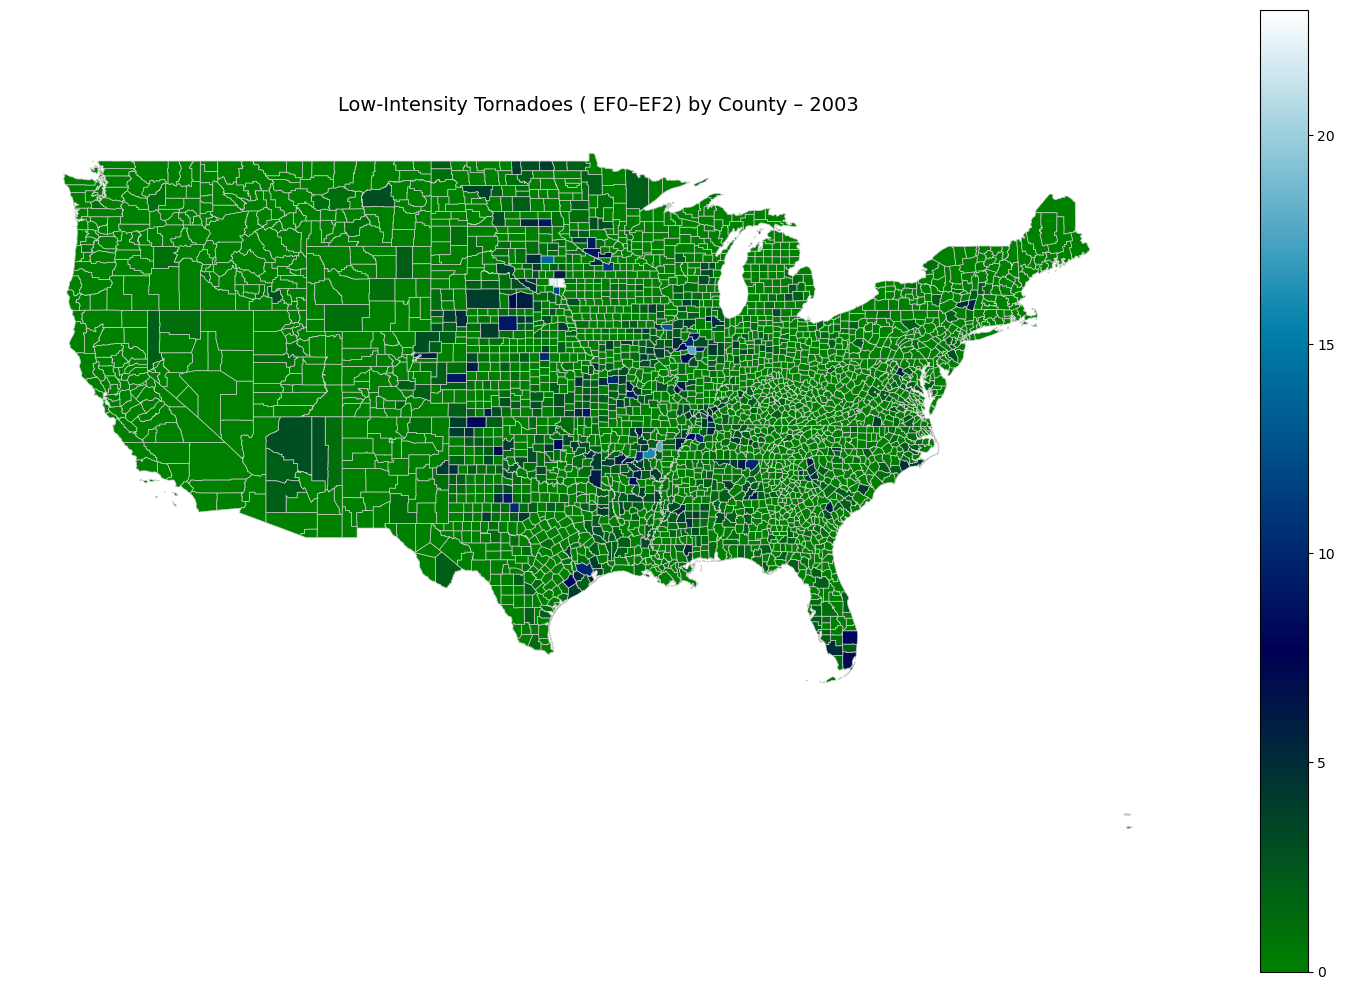

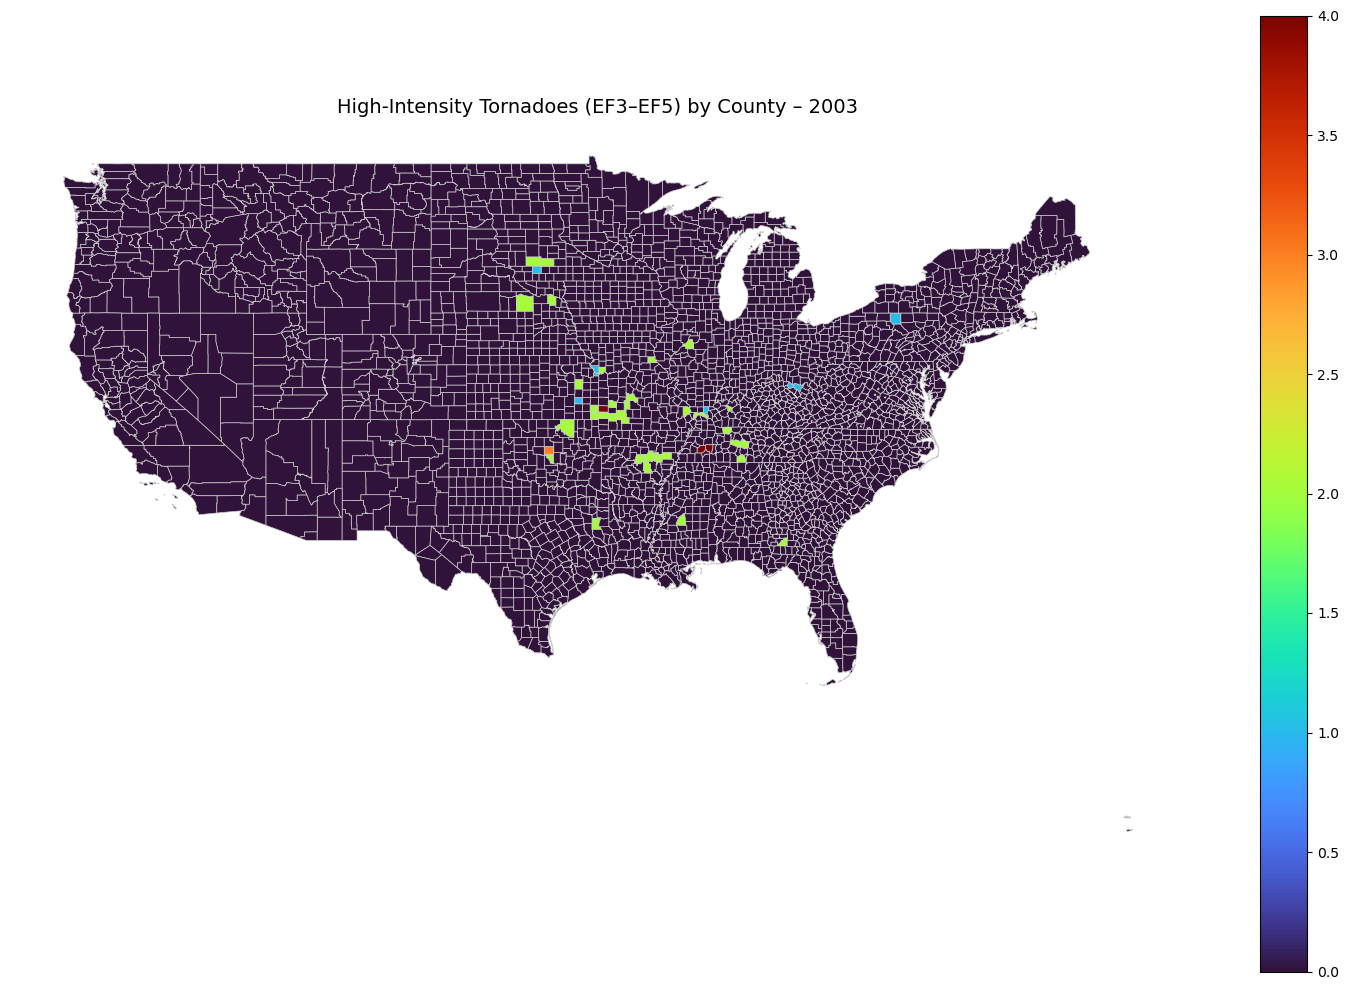

In [30]:

plot_data = counties.merge(tornado_severity_summary, how='left', on=['STATE_NAME', 'NAME'])



# Fill missing tornado counts with 0
plot_data['High'] = plot_data['High'].fillna(0)
plot_data['Low'] = plot_data['Low'].fillna(0)


contiguous = plot_data[~plot_data['STATE_NAME'].isin(contiguous_states)]

# Low-intensity tornado map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
contiguous.plot(column='Low', cmap='ocean', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)
ax.set_title("Low-Intensity Tornadoes ( EF0–EF2) by County – 2003", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# High-intensity tornado map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
contiguous.plot(column='High', cmap='turbo', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)
ax.set_title("High-Intensity Tornadoes (EF3–EF5) by County – 2003", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

